In [40]:
# Cell 1: Imports and constants
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.neighbors import KNeighborsClassifier
import pickle

IMG_SIZE = (32, 32)
K = 3  # For KNN
FONT = cv2.FONT_HERSHEY_SIMPLEX

def show_img(title, img, cmap='gray'):
    plt.figure(figsize=(6, 4))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()


In [41]:
# Cell 2: Load and prepare training data
def load_data(folder):
    X, y = [], []
    classes = os.listdir(folder)
    for cls in classes:
        class_folder = os.path.join(folder, cls)
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, IMG_SIZE)
            X.append(img.flatten())
            y.append(cls)
    return np.array(X), np.array(y)

X_train, y_train = load_data("/content/drive/MyDrive/datasets/train-test-25/train_char")
print("Training samples:", len(X_train))


Training samples: 260


In [84]:
# Cell 3: Train and save KNN model
knn = KNeighborsClassifier(n_neighbors=K)
# splitting for testing accuracy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
knn.fit(X_train, y_train)

print("Training accuracy:", knn.score(X_train, y_train))
print("Testing accuracy:", knn.score(X_test, y_test))

# Save the model
with open("knn_model.pkl", "wb") as f:
    pickle.dump(knn, f)

Training accuracy: 0.8317307692307693
Testing accuracy: 0.7884615384615384


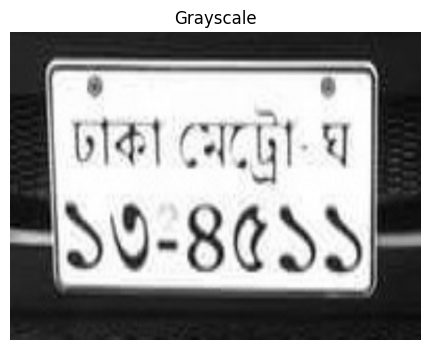

In [85]:
# Cell 4: Load test image and convert to grayscale
img = cv2.imread("/content/drive/MyDrive/datasets/train-test-25/train/Vehicle1315.jpg")
img = cv2.resize(img, (640, 480))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_img("Grayscale", gray)

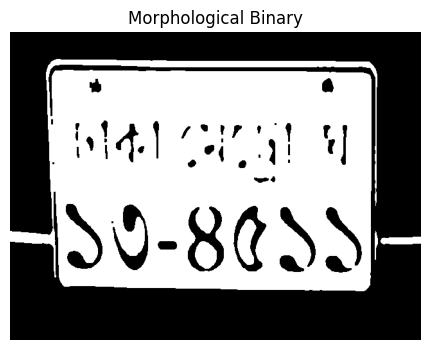

In [67]:
# Cell 5: Morphology
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

show_img("Morphological Binary", morph)

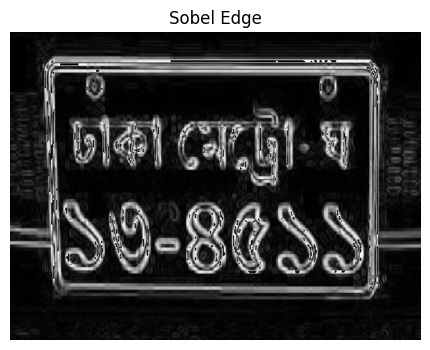

In [68]:
# Cell 6: Edge Detection
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
sobel = np.sqrt(sobel_x**2 + sobel_y**2)
sobel = np.uint8(sobel)

show_img("Sobel Edge", sobel)

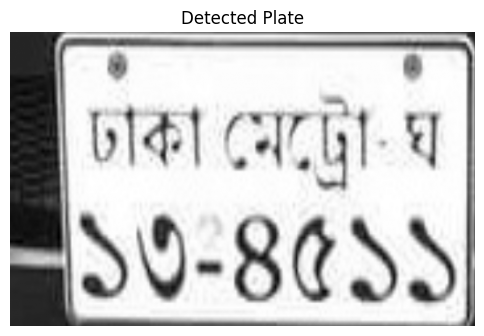

In [81]:
# Cell 7: Plate Extraction
contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

plate_region = None
for cnt in contours:
    area = cv2.contourArea(cnt)

    if area > 3000:
        x, y, w, h = cv2.boundingRect(cnt)
        ratio = w / (h)
        plate_region = gray[y:y+h, x:x+w]
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        break

if plate_region is not None:
    show_img("Detected Plate", plate_region)
else:
    print("No plate detected")

In [73]:
# Cell 8: Color Detection
def detect_plate_color(cropped_img):
    mean_color = cv2.mean(cropped_img)[:3]
    B, G, R = mean_color
    if G > R and G > B and G > 100:
        return "Commercial (Green Plate)"
    else:
        return "Private (White Plate)"

plate_color = detect_plate_color(img[y:y+h, x:x+w])
print("Plate Type:", plate_color)


Plate Type: Commercial (Green Plate)


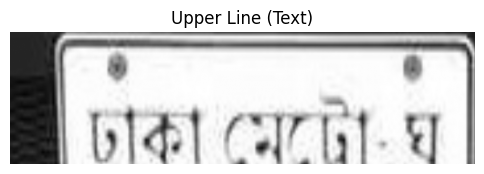

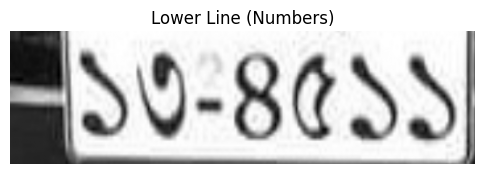

In [74]:
# Cell 9: Line Segmentation
plate = plate_region
h = plate.shape[0]
upper = plate[0:int(h*0.45), :]
lower = plate[int(h*0.55):, :]

show_img("Upper Line (Text)", upper)
show_img("Lower Line (Numbers)", lower)


In [75]:
# Cell 10: Extract characters from a line
def extract_characters(line_img):
    _, th = cv2.threshold(line_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = [cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > 50]
    boxes = sorted(boxes, key=lambda x: x[0])  # sort left to right

    characters = []
    for x, y, w, h in boxes:
        char_img = th[y:y+h, x:x+w]
        char_img = cv2.resize(char_img, IMG_SIZE)
        characters.append(char_img.flatten())

    return characters

upper_chars = extract_characters(upper)
lower_chars = extract_characters(lower)

print(f"Upper line characters: {len(upper_chars)}")
print(f"Lower line characters: {len(lower_chars)}")


Upper line characters: 21
Lower line characters: 8


In [79]:
# Cell 11: Predict using trained KNN
with open("knn_model.pkl", "rb") as f:
    knn = pickle.load(f)

upper_preds = knn.predict(upper_chars)
lower_preds = knn.predict(lower_chars)

print(lower_preds)

plate_text = '-'.join([
    ''.join(upper_preds),
    ''.join(lower_preds)
])

#print("Predicted License Plate:", plate_text)


['৬' '৪' '৮' 'গ' '৩' '১' '২' '২']
